# Stability of the Node2Vec embedding

This notebook assesses the stability of the Node2Vec embeddings for different random initializations of the `pytorch_geometric` and the `node2vec` package. To this end, we will generate a graph and compute corresponding node embeddings for the two implementations of the algorithm only varying the random seed but keeping the remaining parameters constant. We will cluster the corresponding embedding hierarchically using agglomerative clustering with average linkage based on the euclidean distances between the individual node embeddings and assess the agreement of the clustering using the adjusted mutual information criterion. Stable embeddings should feature similar structure of the embedding spaces and thus lead to large adjusted mutual information scores for different number of clusters.

---

## 0. Environmental setup

We first load the required packages and libraries.

In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

import torch

from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec as PygNode2Vec
import torch_geometric.transforms as T
from node2vec import Node2Vec


from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score

We will also load a couple functions that we will use later.

In [2]:
def get_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

def process_single_epoch_n2v(model, optimizer, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(model.device), neg_rw.to(model.device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_n2v_model(model, optimizer, loader, n_epochs=300):
    loss_hist = []
    for i in tqdm(range(n_epochs)):
        logging.debug("EPOCH {}/{}".format(i + 1, n_epochs))
        loss = process_single_epoch_n2v(model=model, optimizer=optimizer, loader=loader)
        logging.debug("TRAIN loss:", loss)
        logging.debug("---" * 30)
        loss_hist.append(loss) 
    print("Final loss:", loss)
    return model, loss_hist

def get_n2v_latents_for_seed(
    graph_data,
    seeds,
    latent_dim=64,
    walk_length=30,
    context_size=10,
    walks_per_node=50,
    batch_size=128,
    num_workers=10,
    lr=0.01,
    n_epochs=100,
    plot_loss=False,
    device=None,
):
    if device is None:
        device = get_device()

    latents_dict = {}
    for seed in seeds:
        # Change initialization
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

        n2v_model = PygNode2Vec(
            graph_data.edge_index,
            embedding_dim=latent_dim,
            walk_length=walk_length,
            context_size=context_size,
            walks_per_node=walks_per_node,
            num_negative_samples=1,
            p=1,
            q=1,
            sparse=True,
        ).to(device)
        n2v_model.device = device

        n2v_loader = n2v_model.loader(
            batch_size=batch_size, shuffle=True, num_workers=num_workers
        )
        n2v_optimizer = torch.optim.SparseAdam(list(n2v_model.parameters()), lr=lr)

        fitted_n2v_model, loss_hist = train_n2v_model(
            model=n2v_model,
            optimizer=n2v_optimizer,
            loader=n2v_loader,
            n_epochs=n_epochs,
        )

        fitted_n2v_model.eval()
        latents = (
            fitted_n2v_model(torch.arange(graph_data.num_nodes, device=device))
            .cpu()
            .detach()
            .numpy()
        )

        latents_dict[seed] = latents

        if plot_loss:
            fig, ax = plt.subplots(figsize=[6, 4])
            ax.plot(np.arange(1, n_epochs + 1), loss_hist)
            fig.suptitle("Loss during training")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
    return latents_dict


def stability_cocluster_screen(latents_dict, affinity="euclidean", linkage="average"):
    ami_matrices = []
    ks = latents_dict.keys()
    latents = list(latents_dict.values())
    for i in range(len(latents)):
        for j in tqdm(range(len(latents))):
            ami_matrices.append(
                compute_ami_matrix(
                    latents[i], latents[j], affinity=affinity, linkage=linkage
                )
            )
    return ami_matrices


def compute_ami_matrix(latents_1, latents_2, affinity="euclidean", linkage="average"):
    # For the sake of the speed of the analyses we restrict the number of clusters of our study to any number
    # between 1 and 15. Larger number of clusters are likely less meaningful and we are mostly interest in the
    # global structure of the embeddings.
    ami = np.zeros([15, 15])
    for i in range(0, 15):
        cluster_sol1 = AgglomerativeClustering(
            affinity=affinity, n_clusters=i + 1, linkage=linkage
        ).fit_predict(latents_1)
        for j in range(0, 15):
            cluster_sol2 = AgglomerativeClustering(
                affinity=affinity, n_clusters=j + 1, linkage=linkage
            ).fit_predict(latents_2)

            ami[i, j] = adjusted_mutual_info_score(cluster_sol1, cluster_sol2)
    return ami


def plot_amis_matrices(seeds, amis, figsize=[16, 16]):
    fig, ax = plt.subplots(figsize=figsize, ncols=len(seeds), nrows=len(seeds))
    ax = ax.flatten()
    j = 0
    for i in range(len(ax)):
        if amis[i] is not None:
            ax[i] = sns.heatmap(
                amis[i],
                ax=ax[i],
                vmin=0,
                vmax=1,
                cbar=((i + 1) % (len(seeds)) == 0),
                cmap="seismic",
            )
            ax[i].text(
                4,
                7.5,
                "max AMI: {:.2f}".format(np.max(amis[i][1:, 1:])),
                c="yellow",
                weight="semibold",
            )
        else:
            ax[i].text(0.5, 0.5, seeds[j])
            j += 1
    plt.show()


---

## 1. Data preparation

We now construct a random sparse graph for simplicity for which we aim to derive node embeddings.

In [3]:
graph = nx.fast_gnp_random_graph(n=150, p=0.05, seed=1234)
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 150
Number of edges: 553
Average degree:   7.3733


Next, we transform the graph into an object that can be processed by the `pytorch_geometric` implementation of Node2Vec and push it to the GPU.

In [4]:
device = get_device()
graph_data = from_networkx(graph)
graph_data = T.ToDevice(device)(graph_data)
graph_data

Data(edge_index=[2, 1106], num_nodes=150)

---

## 2. Stability assessment

We will now run the previously described stability assessment, starting with the Node2Vec implementation of the `pytorch_geometric` package.


### 2.1. `Pytorch_Geometric` implementation

In [5]:
seeds = [1234, 2345, 3456, 4567, 5678]

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]

Final loss: 1.305701023653934


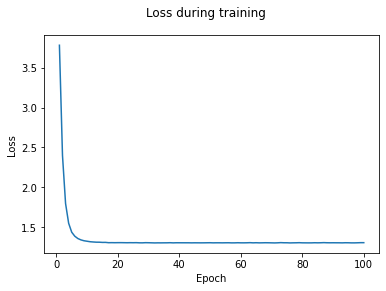

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]

Final loss: 1.3057393180696588


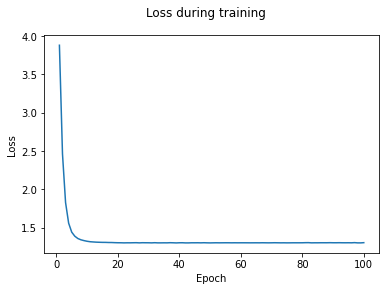

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

Final loss: 1.3034979387333518


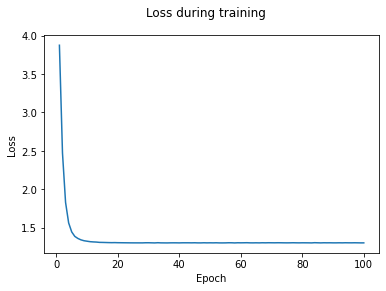

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

Final loss: 1.3040623319776434


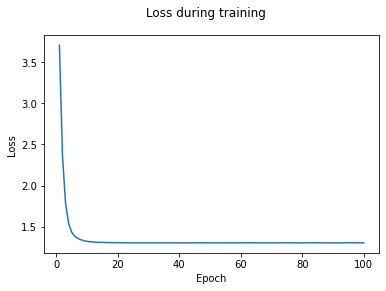

100%|██████████| 100/100 [00:40<00:00,  2.50it/s]

Final loss: 1.3055135450865094


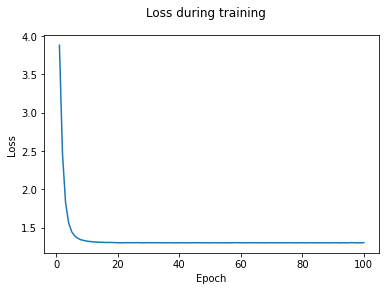

In [6]:
latents_dict_n2v_pyg = get_n2v_latents_for_seed(graph_data,
    seeds,
    latent_dim=32,
    walk_length=50,
    context_size=10,
    walks_per_node=20,
    batch_size=4,
    num_workers=4,
    lr=0.01,
    n_epochs=100,
    plot_loss=True,)

In [7]:
stability_amis_n2v_pyg = stability_cocluster_screen(
    latents_dict_n2v_pyg, linkage="average", affinity="euclidean"
)

100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


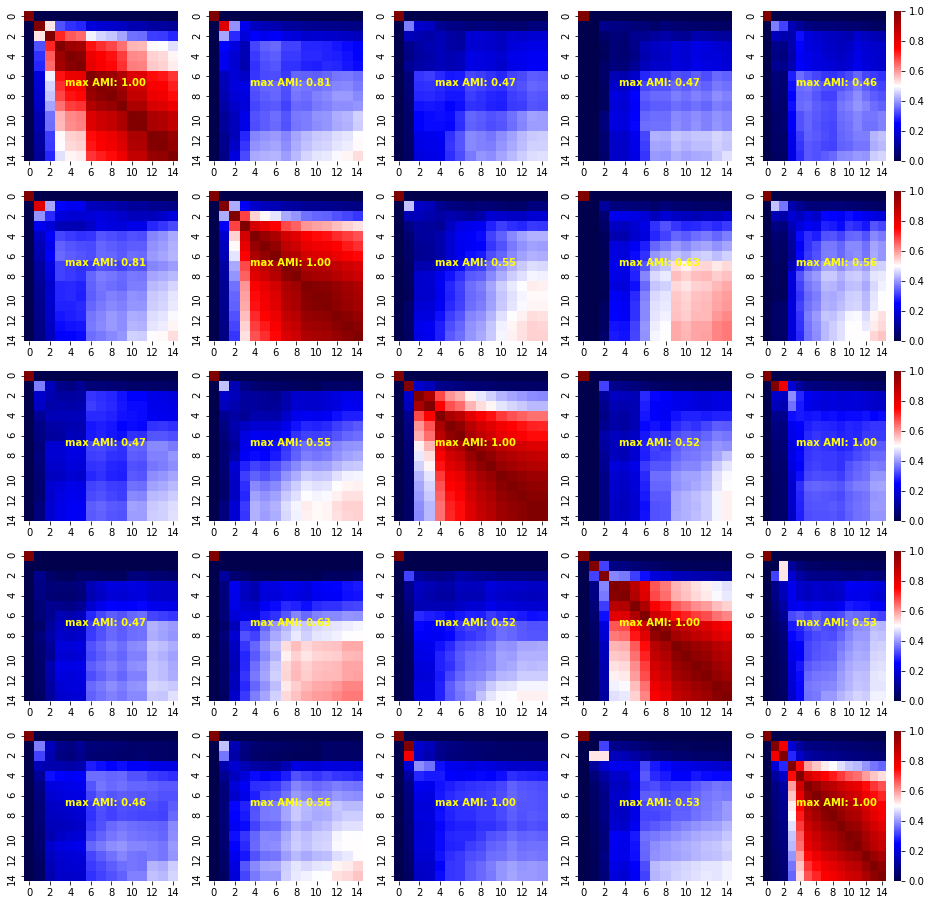

In [8]:
plot_amis_matrices(seeds, stability_amis_n2v_pyg)

The above figure shows a number of heatmaps as a visualization of the adjusted mutual information of the cluster solutions of the embeddings spaces obtained for varying random seeds. Each row and column of the pairs plot above correspond to a different choice of the seeds, i.e. the plot in row $i,j$ correspond to the assessment of the co-clustering of the embedding spaces obtained for training the Node2Vec model with the random state initialized ad seed $i$ and $j$ respectively. Each individual plot shows a color-coded matrix, where the element at the position $k,l$ quantifies the adjusted mutual information when comparing the cluster solution we obtain for $k$ clusters in the embedding space $i$ and $l$ clusters in the embedding space $j$.

We see that except for the trivial solution where we have only on large cluster that includes all nodes of the graph (for which the adjusted mutual information is obviously equal to 1), the maximum in the matrices comparing the embeddings for the different seeds pairwise is relatively low indicating different clustering of the different embeddings and thus little stability of the embeddings for varying random initializations.

---

### 2.2. `node2vec` implementation

In [9]:
latents_dict_n2v = {}
for seed in seeds:
    node2vec = Node2Vec(
        graph,
        dimensions=32,
        walk_length=50,
        num_walks=20,
        workers=4,
        seed=seed,
    )
    
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    latents = []

    for node in list(range(len(graph.nodes()))):
        latents.append(model.wv[node])
    latents_dict_n2v[seed] = np.array(latents)

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

In [10]:
stability_amis_n2v = stability_cocluster_screen(
    latents_dict_n2v, linkage="average", affinity="euclidean"
)

100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


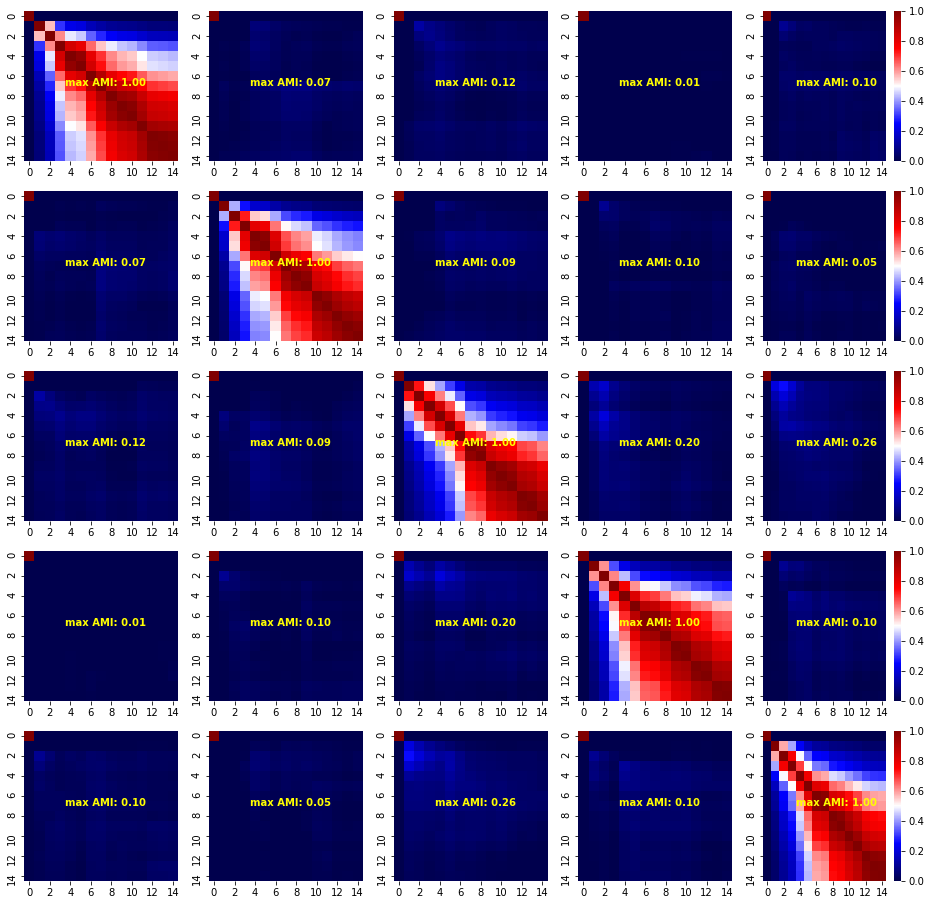

In [11]:
plot_amis_matrices(seeds, stability_amis_n2v)

---

However, we even less agreement using the implementation of `node2vec`. The stability seems to be highly influenced however by the hyperparameter choice, so one might want to select those such that the obtained embeddings are stable.